In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from rbergomi import *
from utilities import *
from mpl_toolkits import mplot3d
from itertools import chain
from matplotlib import cm

# Example: Sample Paths for Price and Volatility

In [34]:
# set parameters
S_0 = 100
K = 100
r = 0
v_0 = 0.3**2
nu = 0.8
H = 0.1
rho = -0.8
T = 1
N = 100
paths = 200

# initialize rBergomi class with parameters
rb = rBergomi(hurst=H, time_steps=N, time_to_maturity=T,
                             rho=rho, spot_variance=v_0, spot_price=S_0, vol_of_vol=nu)

# create lower diagonal matrix from Cholesky decomposition
rb.make_cholesky_matrix()

# get price and vol. paths
prices, vols = rb.get_log_price_paths(paths)


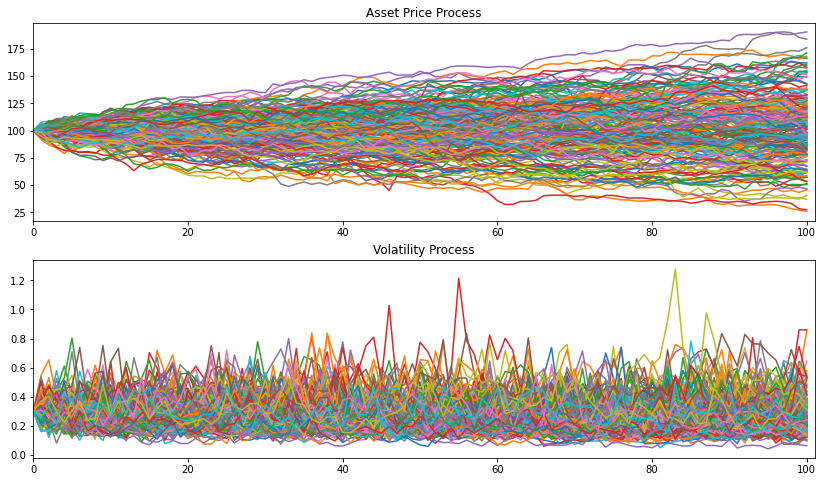

In [4]:
fig, axs = plt.subplots(2,figsize=(14,8))

# asset price
prices = np.exp(prices).T
axs[0].plot(prices)
axs[0].title.set_text("Asset Price Process")
axs[0].set_xlim(xmin=0, xmax=len(prices))

# vol. 
sigs = vols.T
axs[1].plot(sigs)
axs[1].title.set_text("Volatility Process")
axs[1].set_xlim(xmin=0, xmax=len(sigs))

#plt.savefig('Figures/Price_and_vol_paths.png')
plt.show()


## Create Figure with Implied Volatility Skews for Different Maturities

In [11]:
# set parameters
H = 0.07
N = 100
T = [1/3, 2/4, 3/4, 6/4, 8/4]
rho = -0.9 #-0.2
v0 = 0.05
S0 = 100
nu = 1.8

# set log strikes
k = np.arange(-0.4, 0.41, 0.01)
K = np.exp(k)*S0

# empty list to store IV for each maturity
iv_time = []

# vectorize inverse Black-Scholes function
vec_bs_inv = np.vectorize(bs_inv)

# loop through maturities, calculate option prices, and then compute (BS) IV
for t in T:
    
    rb = rBergomi(hurst=H, time_steps=N, time_to_maturity=t, rho=rho, spot_variance=v0, spot_price=S0, vol_of_vol=nu)
    rb.make_cholesky_matrix()
    
    prices, _ = rb.get_option_price(K, mc_runs=1000000)
    
    iv = vec_bs_inv(prices, S_0, K, 0, t)
    iv_time.append(iv)

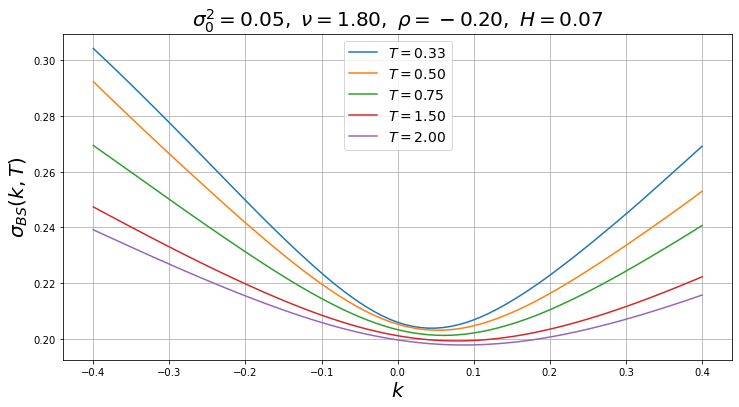

In [12]:
# plot results
plt.figure(figsize=(12,6))

for i in range(len(iv_time)):
    plt.plot(k, iv_time[i], label= r'$T=%.2f$' %T[i])

plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$\sigma_{BS}(k,T)$', fontsize=20)
title = r'$\sigma_{0}^{2}=%.2f,\ \nu=%.2f,\ \rho=%.2f,\ H=%.2f $'
plt.title(title%(v0, nu, rho, H), fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
#plt.savefig('Figures/rBergomi_vol_smile_rho_close_to_0.png')
plt.show()

## Create Figure with ATM Implied Volatility Skew Slope

In [35]:
# function to calculate ATM IV and skew
def atm_vol_and_skew(hurst, time_steps, tau, rho, spot_variance, spot_price, vol_of_vol, h=1e-2):

    ### initiate rBergomi
    # create instance of rBergomi model
    rb = rBergomi(hurst, time_steps, tau, rho, spot_variance, spot_price, vol_of_vol)
    
    # create Cholesky matrix
    rb.make_cholesky_matrix()
    
    # ATM strikes and strikes around ATM for calculation of numerical derivative
    K = [S_0+np.exp(h), S_0, S_0-np.exp(h)]
    
    # get prices
    prices,_ = rb.get_option_price(K, mc_runs=1000000)
    
    # set 'left and right' prices (k+h)
    left = bs_inv(prices[0], S_0=S_0, K=K[0], r=0, T=tau)
    right = bs_inv(prices[2], S_0=S_0, K=K[2], r=0, T=tau)
    
    # calculate psi/skew
    psi = np.abs((left-right)/(2*h))
    
    # calculate atm_vol
    atm_vol = bs_inv(prices[1], S_0=S_0, K=K[1], r=0, T=tau)
    
    return psi, atm_vol

In [36]:
H = 0.07
N = 100
T = [6/2**i for i in range(1, 10)] 
rho = -0.9
v0 = 0.05
S0 = 100
nu = 1.8

skew_list = []
atm_vol_list = []

for t in T:
    skew, atm_vol = atm_vol_and_skew(hurst=H, time_steps=N, tau=t, rho=rho, spot_variance=v0, spot_price=S0, vol_of_vol=nu)
    skew_list.append(skew)
    atm_vol_list.append(atm_vol)

#### Fit Power-law to ATMI Skew Slope

In [37]:
# fit power law
def func_powerlaw(x, m, c):
    return x**m * c

target_func = func_powerlaw

X = T
y = skew_list


coefs_powerlaw = curve_fit(func_powerlaw, X, y, maxfev=10000)
A = coefs_powerlaw[0][1]
alpha = coefs_powerlaw[0][0]
tau = T
res = []

for i in range(len(tau)):
    res.append(A*tau[i]**alpha)

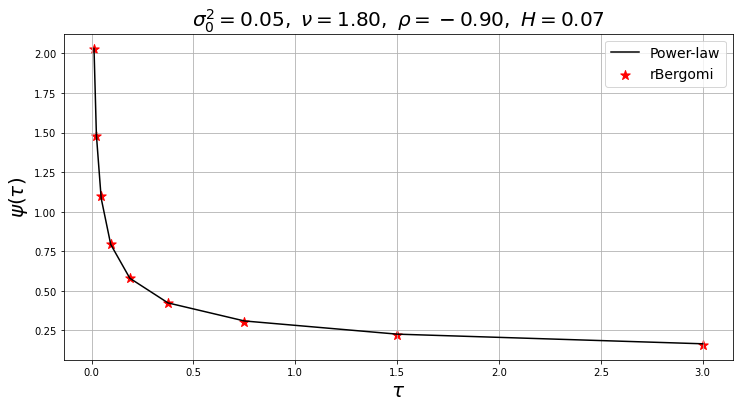

In [38]:
plt.figure(figsize=(12,6))
plt.ylabel(r'$\psi(\tau)$', fontsize=20)
plt.xlabel(r'$\tau$', fontsize=20)
title = r'$\sigma_{0}^{2}=%.2f,\ \nu=%.2f,\ \rho=%.2f,\ H=%.2f $'
plt.title(title%(v0, nu, rho, H), fontsize=20)
plt.scatter(T, skew_list, c='red', label='rBergomi', marker='*', s=100)
plt.plot(tau, res, c='black', label='Power-law')
plt.legend(fontsize=14)
plt.grid(True)
#plt.savefig('Figures/rBergomi_ATM_vol_skew_H_0.07.png')
plt.show()


## Create Figure with Implied Volatility Surface

In [39]:
H = 0.07
N = 100
T = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
rho = -0.4
v0 = 0.05
S0 = 100
nu = 1.8

k = np.arange(-0.25, 0.26, 0.01)
K = np.exp(k)*S0

iv_time = []
vec_bs_inv = np.vectorize(bs_inv)

for t in T:
    
    rb = rBergomi(hurst=H, time_steps=N, time_to_maturity=t, rho=rho, spot_variance=v0, spot_price=S0, vol_of_vol=nu)
    rb.make_cholesky_matrix()
    
    prices, _ = rb.get_option_price(K, mc_runs=1000000)
    
    iv = vec_bs_inv(prices, S_0, K, 0, t)
    iv_time.append(iv)
    

T_ext = list(np.repeat(T, len(K)))
k_ext = []
k_ext = [k_ext + list(k) for i in range(len(T))]
k_ext = list(chain(*k_ext))
iv_ext = list(chain(*iv_time))

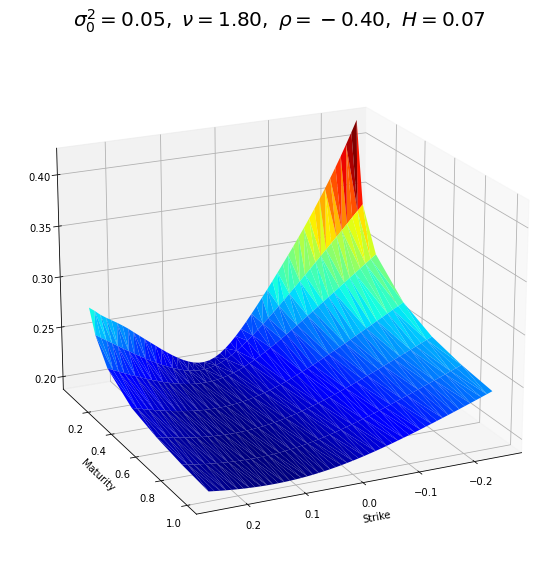

In [50]:
# plot volatility surface 
fig = plt.figure(figsize=(10,10))

axs = plt.axes(projection='3d')

axs.plot_trisurf(k_ext, T_ext, iv_ext, cmap=cm.jet)

axs.view_init(20, 65)

plt.xlabel("Strike")
plt.ylabel("Maturity")

title = r'$\sigma_{0}^{2}=%.2f,\ \nu=%.2f,\ \rho=%.2f,\ H=%.2f $'
plt.title(title%(v0, nu, rho, H), fontsize=20)
#plt.savefig('Figures/rBergomi_example_iv_surface.png')
plt.show()

